https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/homework.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
print(df.shape)
df.head()

(1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0

In [4]:
cat_columns = df.select_dtypes('object').columns.to_list()
cat_columns

['lead_source', 'industry', 'employment_status', 'location']

In [5]:
df[cat_columns].isna().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [6]:
df[cat_columns] = df[cat_columns].fillna('NA')

In [7]:
num_columns = df.select_dtypes('number').columns.to_list()[:-1]
num_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [8]:
df[num_columns].isna().sum()

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64

In [9]:
df[num_columns] = df[num_columns].fillna(0)

In [10]:
target = 'converted'

### Split the data

In [11]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
df_train.shape, df_val.shape, df_test.shape

((876, 9), (293, 9), (293, 9))

In [12]:
y_train = df_train.pop(target).values
y_val = df_val.pop(target).values
y_test = df_test.pop(target).values

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:
* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that

In [13]:
scores = []
for col in num_columns:
    score = roc_auc_score(y_train, df_train[col].values)
    if score < 0.5:
        score = 1 - score
    scores.append([col, score])
df_scores = pd.DataFrame(scores, columns=['column', 'roc_auc_score'])
df_scores.sort_values('roc_auc_score', ascending=False, inplace=True)
df_scores

,column,roc_auc_score
0,number_of_courses_viewed,0.763568
2,interaction_count,0.738270
3,lead_score,0.614499
1,annual_income,0.551958


Which numerical variable (among the following 4) has the highest AUC?

Ans: `number_of_courses_viewed`

### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

In [14]:
def train_model(df, y, C=1):
    dv = DictVectorizer(sparse=False)
    train_dicts = df.to_dict(orient='records')
    X = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [15]:
def evaluate_model(dv, model, df_pred, y_true):
    eval_dicts = df_pred.to_dict(orient='records')
    X_val = dv.transform(eval_dicts)

    y_pred_proba = model.predict_proba(X_val)[:,1]
    socre = roc_auc_score(y_true, y_pred_proba)
    return score, y_pred_proba

In [16]:
dv, model = train_model(df_train, y_train)
score, y_pred_proba = evaluate_model(dv, model, df_val, y_val)
round(score,3)

0.614

Ans: 0.52 (the closest one)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.
* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [17]:
thresholds = np.linspace(0, 1, num=101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [18]:
def precission_recall(y_true, y_pred_proba, threshold):
    
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    tp = ((y_true == 1) & (y_pred == 1)).astype(int).sum()
    tn = ((y_true == 0) & (y_pred == 0)).astype(int).sum()
    fp = ((y_true == 0) & (y_pred == 1)).astype(int).sum()
    fn = ((y_true == 1) & (y_pred == 0)).astype(int).sum()

    precission = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precission, recall

In [19]:
scores = []
for t in thresholds:
    p, r = precission_recall(y_val, y_pred_proba, t)
    scores.append([t, p, r])
df_scores = pd.DataFrame(scores, columns=['threshold','precission','recall'])
df_scores['diff'] = abs(df_scores['precission'] - df_scores['recall'])
df_scores[::10]

/tmp/ipykernel_3828/3111122160.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precission = tp / (tp + fp)


,threshold,precission,recall,diff
0,0.0,0.583618,1.000000,0.416382
10,0.1,0.583618,1.000000,0.416382
20,0.2,0.583618,1.000000,0.416382
30,0.3,0.589655,1.000000,0.410345
40,0.4,0.619565,1.000000,0.380435
50,0.5,0.669388,0.959064,0.289677
60,0.6,0.738916,0.877193,0.138277
70,0.7,0.809160,0.619883,0.189277
80,0.8,0.914286,0.374269,0.540017
90,0.9,0.960000,0.140351,0.819649


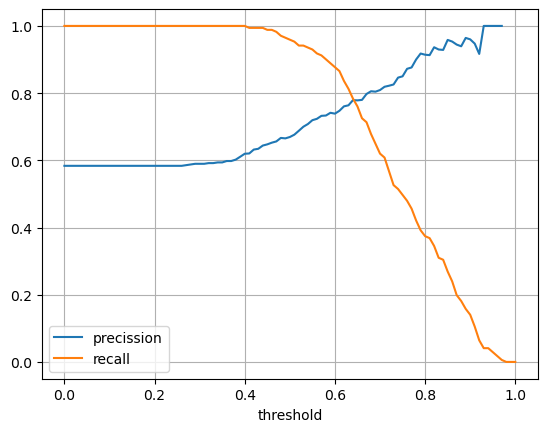

In [20]:
plt.plot(thresholds, df_scores['precission'], label='precission')
plt.plot(thresholds, df_scores['recall'], label='recall')
plt.xlabel('threshold')
plt.grid()
plt.legend();

In [21]:
df_scores.sort_values('diff', ascending=True).head(1)

,threshold,precission,recall,diff
64,0.64,0.77907,0.783626,0.004556


At which threshold precision and recall curves intersect?

Ans: 0.545

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

In [22]:
df_scores['f1'] = 2 * df_scores['precission'] * df_scores['recall'] / (df_scores['precission'] + df_scores['recall'])
df_scores[::10]

,threshold,precission,recall,diff,f1
0,0.0,0.583618,1.000000,0.416382,0.737069
10,0.1,0.583618,1.000000,0.416382,0.737069
20,0.2,0.583618,1.000000,0.416382,0.737069
30,0.3,0.589655,1.000000,0.410345,0.741866
40,0.4,0.619565,1.000000,0.380435,0.765101
50,0.5,0.669388,0.959064,0.289677,0.788462
60,0.6,0.738916,0.877193,0.138277,0.802139
70,0.7,0.809160,0.619883,0.189277,0.701987
80,0.8,0.914286,0.374269,0.540017,0.531120
90,0.9,0.960000,0.140351,0.819649,0.244898


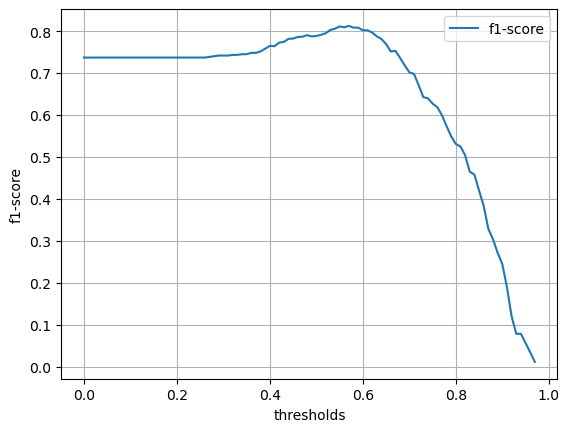

In [23]:
plt.plot(thresholds, df_scores['f1'], label='f1-score')
plt.xlabel("thresholds")
plt.ylabel('f1-score')
plt.grid()
plt.legend();

In [24]:
df_scores.sort_values('f1', ascending=False).head()

,threshold,precission,recall,diff,f1
57,0.57,0.732394,0.912281,0.179886,0.812500
55,0.55,0.719457,0.929825,0.210368,0.811224
56,0.56,0.723502,0.918129,0.194626,0.809278
59,0.59,0.741463,0.888889,0.147425,0.808511
58,0.58,0.733333,0.900585,0.167251,0.808399


At which threshold F1 is maximal?

Ans: 0.54 (the closest one)

### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: `KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [25]:
def kfold_evaluation(C=1):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_train_full):
        
        df_train = df_train_full.iloc[train_idx].copy()
        df_val = df_train_full.iloc[val_idx].copy()
        
        y_train = df_train.pop(target).values
        y_val = df_val.pop(target).values
        
        dv, model = train_model(df_train, y_train, C)
        score, y_pred_proba = evaluate_model(dv, model, df_val, y_val)
    
        scores.append(score)

    print(f"roc_auc_score: {np.mean(scores):.3f} +- {np.std(scores)} (for C = {C})")
    return scores

In [26]:
scores = kfold_evaluation()

roc_auc_score: 0.614 +- 0.0 (for C = 1)


Ans: 0.0001

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C
* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [27]:
for C in [0.000001, 0.001, 1]:
    scores = kfold_evaluation(C)

roc_auc_score: 0.614 +- 0.0 (for C = 1e-06)
roc_auc_score: 0.614 +- 0.0 (for C = 0.001)
roc_auc_score: 0.614 +- 0.0 (for C = 1)


Ans: C = 0.000001